In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier


from skmultiflow.drift_detection.adwin import ADWIN
from skmultiflow.drift_detection.page_hinkley import PageHinkley

from classifier.detector_classifier import DetectorClassifier
from evaluation.prequential import prequential

In [2]:
def read_data(filename):
    df = pd.read_csv(filename)
    data = df.values
    return data[:, :-1], data[:, -1]


SGDClassifier:


/Users/debasishghosh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Mean acc within the window 10000: 0.8412560551296098

Page-Hinkley:


/Users/debasishghosh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Drift detection: 2
Mean acc within the window 10000: 0.9859503178370048

AdWin:


/Users/debasishghosh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Drift detection: 42
Mean acc within the window 10000: 0.9922095716198132


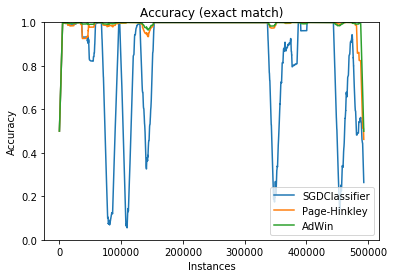

In [3]:
if __name__ == '__main__':
    n_train = 1000
    X, y = read_data("data/kddcup_refactored.csv")
    # Set x,y as numeric
    X = X.astype(float)
    label = ["normal.", "abnormal."]
    
    le = preprocessing.LabelEncoder()
    le.fit(label)
    y = le.transform(y)

    w = 10000

    clfs = [
        SGDClassifier(),
        DetectorClassifier(SGDClassifier(), PageHinkley(), np.unique(y)),
        DetectorClassifier(SGDClassifier(), ADWIN(), np.unique(y))
    ]
    clfs_label = ["SGDClassifier", "Page-Hinkley", "AdWin"]

    plt.title("Accuracy (exact match)")
    plt.xlabel("Instances")
    plt.ylabel("Accuracy")

    for i in range(len(clfs)):
        print("\n{}:".format(clfs_label[i]))
        with np.errstate(divide='ignore', invalid='ignore'):
            y_pre, time = prequential(X, y, clfs[i], n_train)
        if clfs[i].__class__.__name__ == "DetectorClassifier":
            print("Drift detection: {}".format(clfs[i].change_detected))
        estimator = (y[n_train:] == y_pre) * 1

        acc_run = np.convolve(estimator, np.ones((w,)) / w, 'same')
        print("Mean acc within the window {}: {}".format(w, np.mean(acc_run)))
        plt.plot(acc_run, "-", label=clfs_label[i])

    plt.legend(loc='lower right')
    plt.ylim([0, 1])
    plt.show()